TODO: Chang tf-idf to other text representations

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from nltk.stem.snowball import SnowballStemmer
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import re

In [31]:
dataset_path = './archive/train.csv'
data_column  = 'tweet'
SVM			 = False

In [32]:
df = pd.read_csv(dataset_path)

In [33]:
def reduce_repetition(s):
    # use regular expression to find repeated substrings
    pattern = re.compile(r'(.+?)\1{%d,}' % 2)
    match = pattern.search(s)

    # reduce repetition to two occurrences
    while match:
        repeated_substring = match.group(1)
        s = s.replace(match.group(), repeated_substring, 1)
        match = pattern.search(s)

    return s

In [34]:
abbr = {
    'ninstagram'        : 'instagram',
    'instagramgram'     : 'instagram',
    'ig'                : 'instagram',
    'strainstagramht'   : 'instagram',
    'insta'             : 'instagram',
    'rinstagramht'      : 'instagram',
    'ninstagramguh'     : 'instagram',
    'instagramz'        : 'instagram',
    'sinstagramn'       : 'instagram',
    'binstagramgest'    : 'instagram',
    'pinstagram'        : 'instagram',
    'linstagramht'      : 'instagram',
    'ninstagramg'       : 'instagram',
    'instagramh'        : 'instagram',
    'instagramnor'      : 'instagram',
    'ninstagramht'      : 'instagram',
    'ninstagramgramga'  : 'instagram',
    'finstagramht'      : 'instagram',
    'binstagram'        : 'instagram',
    'hinstagramh'       : 'instagram',
    'ninstagramga'      : 'instagram',
    'toninstagramht'    : 'instagram',
    'minstagramht'      : 'instagram',
    'minstagramt'       : 'instagram',
    'dwn'               : 'down',
    'dawn'              : 'down',
    'ta'                : 'that',
    'dat'               : 'that',
    'dawg'              : 'dude',
    'smh'               : 'head',
    'fr'                : 'real',
    'plz'               : 'please',
    'tf'                : 'wtf',
    'theyr'             : 'are',
    'bc'                : 'because',
    'af'                : 'lot',
    'u'                 : 'you',
    'ppl'               : 'people',
    'dm'                : 'message',
    'bf'                : 'friend',
    'gt'                : 'getting',
    'ya'                : 'yes',
    'na'                : 'no',
    'ur'                : 'your',
    'tryna'             : 'to',
    'lmfao'             : 'lmao',
    'ive'               : 'have'
}

In [35]:
def remove_points(line):
    l = list(line)

    for i in range(len(l)):
        if i < len(l) - 2 and l[i] == '.' and 'A' <= l[i+2] <= 'Z':
            l[i] = ' '

    line = ' '.join(l)

In [36]:
stemmer = SnowballStemmer('english')

In [37]:
def preprocess(sentence, get='stems'):
    sent = re.sub(r'@([a-zA-Z0-9_]+)'	, 'username', sentence).replace('username:', '') # replace first username
    sent = re.sub(r'http?://\S+'		, 'weblink'	, sent	  )
    sent = re.sub(r'&amp'				, '&'		, sent	  )
    sent = re.sub(r"&#\d+"				, ''		, sent	  )
    
    if sent and sent[0] == '.':
        sent = sent[1:]

    remove_points(sent)
    sent = sent   .replace('RT', '').replace('!', ' ').replace('"', '').replace("\n", ' ')\
                        .replace(';', ' ').replace('-', ' ').replace(' and ', ' & ').replace('\'', '')\
                        .replace('?', '.').replace(',', '').replace('~', ' ').replace('|', ' ').replace('°', ' ')\
                        .replace('`', ' ').replace('~', ' ').replace('*', ' ').replace('+', ' ').replace('/', ' ')\
                        .replace(' # ', ' ').replace('http', ' ').replace('t.co', ' ').replace('\\', ' ').replace('&#', ' ')
    for _ in range(4):
        sent = sent.replace('  ', ' ').replace('..', '.').replace(' .', '.') # remove multiple points & space
    
    if sent and sent[0] == ' ':
        sent = sent[1:]

    sent = sent.lower()

    for old in abbr:
        new = abbr[old]
        sent = sent.replace( ' ' + old + ' ', ' ' + new + ' ' ) # add some space arround the world to avoid matching a part of a word

    sent = reduce_repetition(sent)

    if get == 'sentence':
        return sent
    
    tokens = nltk.word_tokenize(sent)

    for i in range(len(tokens) - 1, 0, -1):
        if len(tokens[i].strip()) == 0 or (len(tokens[i].strip()) == 1 and tokens[i].strip() != 'a' and tokens[i].strip() != 'i' and tokens[i].strip() != '&'):
            tokens.pop(i)

    if get == 'tokens':
        return tokens

    stems = []

    for tok in tokens:
        stems.append(stemmer.stem(tok))

    for i in range(len(stems) - 1, 0, -1):
        if len(stems[i].strip()) == 0:
            stems.pop(i)
        elif len(stems[i].strip()) == 1:
            if 'a' < stems[i].strip() <= 'z'and stems[i].strip() != 'i':
                stems.pop(i)


    for i in range(len(stems) - 1, 0, -1):
        arr = stems[i].split('.')
        stems[i] = arr[0]
        for j in range(1, len(arr)):
            stems.insert(i+j, arr[j])

    for i in range(len(stems)):
        if stems[i] in abbr.keys():
            stems[i] = abbr[stems[i]]

    return stems

In [38]:
df['processed_text'] = df[data_column].apply(preprocess)

In [39]:
df['processed_text_str'] = df['processed_text'].apply(lambda x: " ".join(x))

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text_str']).toarray()

In [40]:
def label_tweet(row):
    """
    - Hate: If hate_speech_count is the highest count.
    - Offensive: If offensive_language_count is the highest count.
    - Hate & Offensive: If hate_speech_count and offensive_language_count are equal and higher than neither_count.
    - Neither: If neither_count is the highest count.
    """
    if row['hate_speech_count'] > row['offensive_language_count'] and row['hate_speech_count'] > row['neither_count']:
        return 'hate'
    elif row['offensive_language_count'] > row['hate_speech_count'] and row['offensive_language_count'] > row['neither_count']:
        return 'hate'
    elif row['hate_speech_count'] == row['offensive_language_count'] and row['hate_speech_count'] > row['neither_count']:
        return 'hate'
    else:
        return 'neither'

In [41]:
df['label'] = df.apply(label_tweet, axis=1)

In [42]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

In [43]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{'hate': 0, 'neither': 1}


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

**Logistic Regression** Model

In [45]:
if not SVM:
	logistic_model = LogisticRegression(max_iter=5000)
	logistic_model.fit(X_train, y_train)

In [62]:
if not SVM:
	logistic_predictions = logistic_model.predict_proba(X_test)

**SVM** Model

In [63]:
if SVM:
	svm_model = SVC()

In [64]:
if SVM:	
	svm_model.fit(X_train, y_train)

In [65]:
from joblib import dump, load

# save / load the model
# dump(svm_model, './models/svm-3.joblib')
svm_model = load('./models/svm-2.joblib')

In [66]:
if SVM:
	svm_predictions = svm_model.predict_proba(X_test)

In [67]:
# Evaluation function
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

In [68]:
# Evaluating the models
if not SVM: logistic_eval = evaluate_model(y_test, logistic_predictions)
if SVM: svm_eval = evaluate_model(y_test, svm_predictions)

if not SVM: print("Logistic Regression - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(*logistic_eval))
if SVM: print("SVM - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(*svm_eval))

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(	j, i, format(cm[i, j], fmt),
					horizontalalignment="center",
					color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix


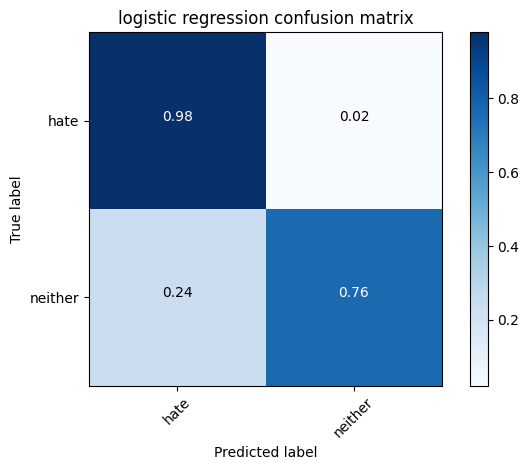

In [ ]:
if not SVM:
	plot_confusion_matrix(y_test, logistic_predictions, classes=label_mapping.keys(), normalize=True, title='logistic regression confusion matrix')

In [ ]:
if SVM: plot_confusion_matrix(y_test, svm_predictions, classes=label_mapping.keys(), normalize=True, title='SVM confusion matrix')

In [ ]:
print(svm_model)

SVC(probability=True)


In [ ]:
if SVM:
	predictions = svm_model.predict(X_test_tfidf.toarray())
	for sentence, prediction in zip(test, predictions):
		print(f"{sentence}\t{prediction}")

In [84]:

feature_names = tfidf_vectorizer.get_feature_names_out()

coefficients = logistic_model.coef_[0]

feature_importance = sorted(zip(coefficients, feature_names), key=lambda x: abs(x[0]), reverse=True)

print("Most important features in the logistic regression model:")
for coef, feat in feature_importance[:100]:
    print(f"{feat}:\t{coef:2.2f}")

Most important features in the logistic regression model:
bitch:	-21.86
hoe:	-11.87
pussi:	-10.54
fuck:	-8.50
shit:	-7.04
bird:	6.25
faggot:	-6.23
ass:	-6.22
nigga:	-6.16
yanke:	6.15
charli:	5.58
nigger:	-5.43
yellow:	5.41
cunt:	-4.80
fag:	-4.66
white:	-4.31
oreo:	4.27
trash:	4.22
niggah:	-4.22
retard:	-3.88
browni:	3.88
mock:	3.75
sole:	3.64
jihadi:	3.30
color:	3.20
fuckin:	-3.08
dick:	-2.85
monkey:	2.84
nigguh:	-2.84
zebra:	2.69
these:	-2.62
queer:	-2.59
nicca:	-2.58
clam:	2.52
dyke:	-2.45
nig:	-2.44
redskin:	2.41
yo:	-2.37
her:	-2.29
fuzzi:	2.24
you:	-2.24
slope:	2.21
ape:	2.16
damn:	-2.14
jig:	2.11
aint:	-2.01
chug:	1.99
yank:	1.97
ghetto:	1.97
weblink:	1.95
crow:	1.90
twinki:	1.75
yall:	-1.74
shi:	1.74
hun:	1.74
she:	-1.70
hoosier:	1.70
yes:	-1.68
that:	-1.64
beani:	1.64
fairi:	1.56
chunki:	1.53
via:	1.53
law:	1.52
wit:	-1.51
hick:	1.51
hillbilli:	1.51
women:	-1.50
wtf:	-1.50
insid:	1.48
game:	1.43
abo:	1.42
stfu:	-1.42
my:	-1.38
twat:	-1.38
wetback:	-1.34
hate:	-1.31
amo:	1.31
fo